In [191]:
# merge_all.csv 파일을 사용하여 "가격 (원)" 컬럼의 값을 예측하는 모델을 만든다

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [192]:
# 데이터 불러오기
df = pd.read_csv('data/merge_all/merge_all.csv')
df.head()

# 데이터 전처리
# "거래년월일" 컬럼을 인덱스로 설정
df = df.set_index('거래년월일')
df.head()

,자동차용 경유 가격 (원),전월비(%),평균,거래량
거래년월일,,,,
2000-01-01,583.35,4.0,5600.0,102285.0
2000-01-02,583.35,4.0,5600.0,102285.0
2000-01-03,583.35,4.0,5600.0,102285.0
2000-01-04,583.35,4.0,5600.0,715338.0
2000-01-05,583.35,4.0,5620.0,340568.0


In [193]:
# usiing df to predict "평균" column
target = df[['평균']]

# target value predict
# target value를 예측하기 위해 1일 전의 데이터를 사용한다
# 1일 전의 데이터를 사용하기 위해 lag를 1로 설정한다
target['lag_1'] = target['평균'].shift(1)
target.head()

# 결측치 제거
target = target.dropna()

# 데이터 분할
# train : test = 7 : 3
train = target[:int(len(target)*0.7)]
test = target[int(len(target)*0.7):]

# 데이터 스케일링
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

# 데이터셋 생성
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# time_step = 1
time_step = 1
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

# 데이터셋 형태 확인
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# 데이터셋 reshape
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# 데이터셋 형태 확인
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# 모델 생성
model = Sequential()
model.add(LSTM(32, input_shape=(1, time_step)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# 모델 학습
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

# 모델 예측
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)





(5856, 1) (5856,)
(2509, 1) (2509,)
(5856, 1, 1) (5856,)
(2509, 1, 1) (2509,)
Epoch 1/100


2022-12-22 13:16:27.578080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:16:27.753138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:16:27.905466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 620/5856 [==>...........................] - ETA: 45s - loss: 0.0053

KeyboardInterrupt: 

In [ ]:
# 모델 평가
# train data
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: ', trainScore)
# r2 score
from sklearn.metrics import r2_score
r2_train = r2_score(y_train, train_predict)
print('Train R2 Score: ', r2_train)


# test data
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: ', testScore)
# r2 score
r2_test = r2_score(y_test, test_predict)
print('Test R2 Score: ', r2_test)







Train Score:  0.00015051553782541305
Train R2 Score:  0.9856502072354821
Test Score:  0.0005291398265399039
Test R2 Score:  0.9809270420809189


In [ ]:
#  모델 저장
model.save('model/predict_price.h5')


 1/79 [..............................] - ETA: 22s

2022-12-22 13:16:41.746821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:16:41.795846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 1s 6ms/step


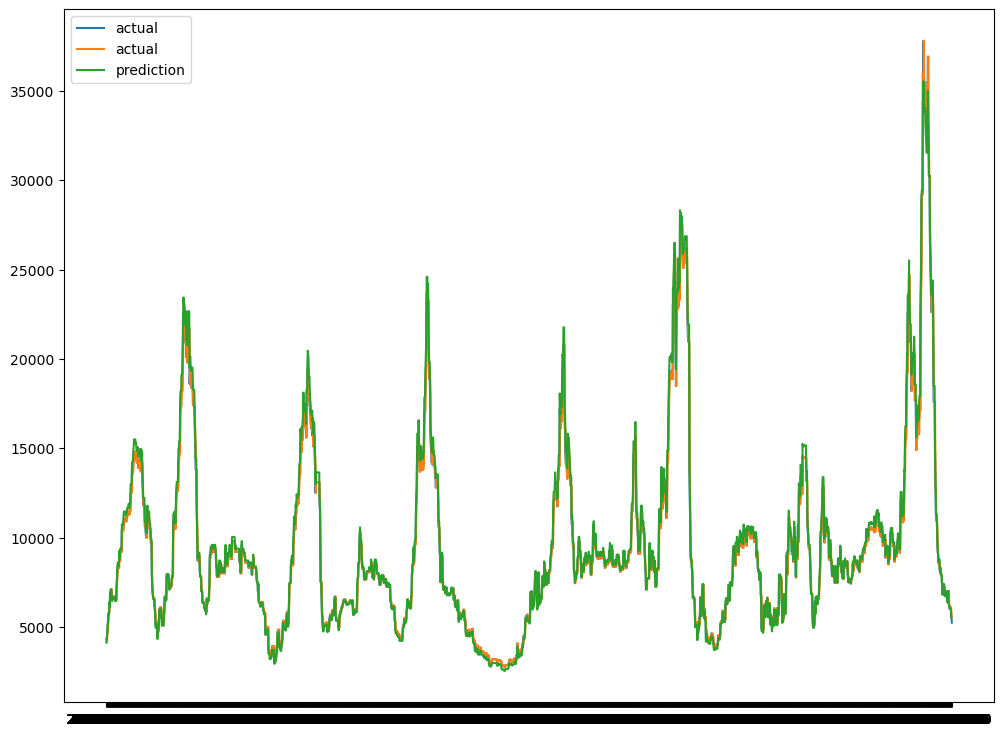

In [194]:
# 모델 불러오기
from keras.models import load_model
model = load_model('model/predict_price.h5')

target_predict = model.predict(X_test)
# target_predict shape  (2509,1) -> (2509,2) 
target_predict = np.concatenate((target_predict, X_test.reshape(X_test.shape[0], X_test.shape[2])), axis=1)
# X_test.shape


# 역 스케일링
train_predict = scaler.inverse_transform(target_predict)
train_predict

# 예측 결과 시각화
plt.figure(figsize=(12, 9))
plt.plot(target[int(len(target)*0.7):], label='actual')
plt.plot(train_predict[:, 0], label='prediction')
plt.legend()
plt.show()







In [197]:
# data/price/price_baechoo.csv 를 이용하여 예측
# 데이터 불러오기
target_test = pd.read_csv('data/price/price_baechoo.csv')

# 데이터 전처리
# "거래년월일" 컬럼을 인덱스로 설정
target_test = target_test.set_index('구분')

# 2022-12-01 부터 데이터만 추출
target_test = target_test['2022-12-01':]
target_test

,평균
구분,
2022-12-01,5462.0
2022-12-05,5982.0
2022-12-06,5502.0
2022-12-07,5488.0
2022-12-08,5408.0
2022-12-09,5408.0
2022-12-12,5244.5
2022-12-13,5245.5
2022-12-14,5430.5


In [199]:
# model/predict_price.h5 모델을 이용하여 예측
# 데이터 스케일링
scaler = MinMaxScaler()
scaler.fit(target_test)
target_test = scaler.transform(target_test)

# 데이터셋 생성
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# time_step = 1
time_step = 1
X_test, y_test = create_dataset(target_test, time_step)

# 데이터셋 reshape
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# 모델 불러오기
from keras.models import load_model
model = load_model('model/predict_price.h5')

# 모델 예측
target_predict = model.predict(X_test)
target_predict



1/1 [==============================] - 0s 306ms/step


2022-12-22 13:21:45.227817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:21:45.274203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[ 0.3056194 ],
       [ 0.9827131 ],
       [ 0.36508405],
       [ 0.34428537],
       [ 0.22552386],
       [ 0.22552386],
       [-0.00740442],
       [-0.00605309],
       [ 0.2588245 ],
       [ 0.2588245 ],
       [ 0.07484943]], dtype=float32)

In [202]:
#  성능 평가
# test data
testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: ', testScore)
# r2 score
r2_test = r2_score(y_test, target_predict)
print('Test R2 Score: ', r2_test)



Test Score:  0.09965347498655319
Test R2 Score:  -0.5029124634666207


2022-12-22 13:38:15.347099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-12-22 13:38:15.417411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
